In [218]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns
import doubleml as dml
from sklearn.pipeline import make_pipeline

# Python: Price Elasticities with double/debiased machine learning

In this real-data example, we illustrate how the DoubleML package can be used to estimate price elasticities of demand.  We use data set from a UK retail firm. The estimation of price elasticities has also been explored by [Erik Kaunismäki (2021)](https://helda.helsinki.fi/dhanken/bitstream/handle/10227/441224/Kaunism%C3%A4ki_Erik.pdf?sequence=1) and [Kuan-Pin Lin (2019)](http://web.pdx.edu/~crkl/BDE/MLE-4.pdf).

We will use a public domain (CC0 1.0 Universal) dataset, sourced from [link](https://www.kaggle.com/vijayuv/onlineretail). We have to highlight that this data has one significant technical limitation: we only observe sales, not stock days. That means we have no data at all about prices on days where 0 sales occurred. It is an issue since typically most of the units are rarely sold; however, we pass over it for the example.

The raw data have hourly sales with information on products' code, quantity and unit price, country, and description of the product. The cleansed data **(ecom_sample_clean.parquet)** for the example dropped out observations with unbelievable high quantities and unit prices since these outliers might mess analysis. Finally, it summarizes individual orders at country, date, and item level. 

## Data Wrangling

We have already preprocesed data from 
It seems that start date sales vary between countries. The sales have been recorded since December 2010.

In [11]:
# Set your kaggle credentials
import os
os.environ['KAGGLE_USERNAME'] = "anzonyquisperojas"
os.environ['KAGGLE_KEY'] = "61a3a692afb863bab26aeb5a49b7e63b"

In [13]:
# Download data
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Extract data from csv
api.dataset_download_files('vijayuv/onlineretail', path=".")

In [16]:
# Unzip files
import zipfile
with zipfile.ZipFile( 'onlineretail.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [155]:
# Importing data
df = pd.read_csv( r'OnlineRetail.csv',  encoding = 'ISO-8859-1' )

len(df)

541909

In [156]:
# Cleaning data
df = df[
    (df.Quantity > 0) &
    (df.UnitPrice > 0)
]

We decided to make evaluation of elasticities not taking into count the following stock code products.

|Stock Code| Description|
|---|---|
|POST|Postage|
|DOT|  Dotcom Postage |
|M| Manual|
|AMAZONFEE| Amazon Fee	|
|BANK CHARGES| Bank Charges |
|C2| Carriage |
|S | Samples |

In [157]:
df = df[ ~df.StockCode.isin( [ 'POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'S' ] ) ]
len(df)

527794

In [158]:
# Give format to columns
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

<AxesSubplot:title={'center':'Number of items sold and number of orders over time'}, xlabel='Date'>

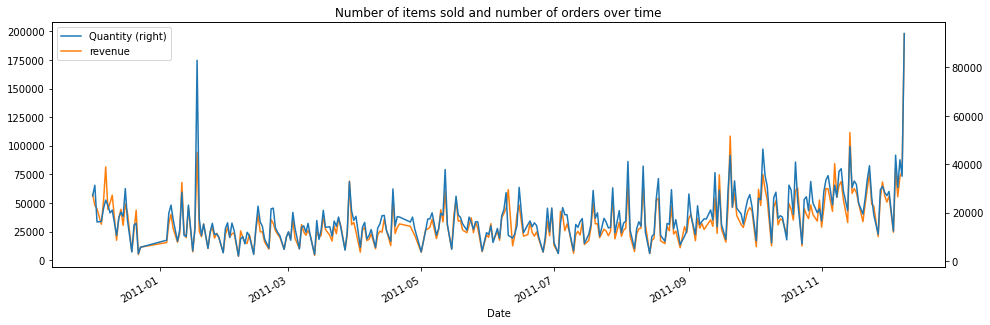

In [159]:
# Inspect data by visualization
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title = 'Number of items sold and number of orders over time',
    secondary_y = 'Quantity',
    figsize = (16, 5)
)

According to the plot, we see high some outliers in quantity. Let see the top 5 quantities and revenues in data.

In [160]:
df.nlargest(5, columns='revenue')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,2011-06-10,38970.00
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,2011-08-12,11062.06
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,2011-09-20,7144.72


In [161]:
df.nlargest(5, columns='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.60
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10-27,1008.00
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,2011-05-27,3096.00
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2011-02-22,3202.92


The top 2 high orders in dataset corresponds to the top 2 revenues. We inspect previous orders from these costumers

In [162]:
df[ df.CustomerID.isin([16446.0, 12346.0]) ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.60
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,2011-05-18,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,2011-05-18,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60


We verified that those order may be unreal or very unsual. We decided to drop these CostumerIDs.

In [163]:
df = df[~df.CustomerID.isin([16446.0, 12346.0])]

Text(0.5, 6.79999999999999, '')

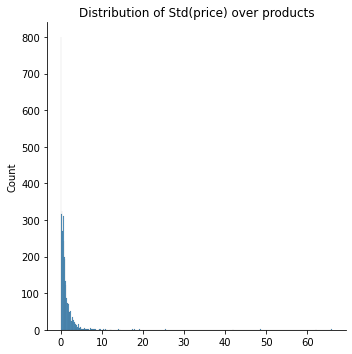

In [164]:
sns.displot(df.groupby('StockCode').UnitPrice.std().dropna(), kde=False)
plt.title('Distribution of Std(price) over products');
plt.xlabel( "" )

In [165]:
df.groupby('StockCode').UnitPrice.std().dropna().nlargest(5)

StockCode
22656    66.039761
22655    62.136568
22826    48.621234
22502    41.924903
22833    25.435572
Name: UnitPrice, dtype: float64

In [166]:
df.shape

(527790, 10)

We keep those observations in which the unit price is greater than 0.33 times its stock code's median price and lower than 3 times its stock code's median price. In other words, we censor observations with implausibly large price deviation.

In [167]:
df = (
    df
    .assign(
        dNormalPrice=lambda d: d.UnitPrice 
            / d.groupby('StockCode').UnitPrice.transform('median') 
    )
    .pipe(
        lambda d: d[
            (d['dNormalPrice'] > 1./3) &
            (d['dNormalPrice'] < 3.)
        ]
    )
    .drop(columns=['dNormalPrice'])
)

In [168]:
df.shape

(518418, 10)

Finally, we summarize data at date, stock code, and country level. 

In [169]:
df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')

df['UnitPrice'] = df['revenue'] / df['Quantity'] # implicit quantity-weighted avg of prices

The data has information since december 2010.

In [170]:
df.groupby('Country').agg(
    {'Date': 'min'} ).sort_values( by = 'Date' ).head( 5 )

,Date
Country,
Australia,2010-12-01
United Kingdom,2010-12-01
Norway,2010-12-01
Germany,2010-12-01
France,2010-12-01


<AxesSubplot:title={'center':'number of items sold and revenue over time'}, xlabel='Date'>

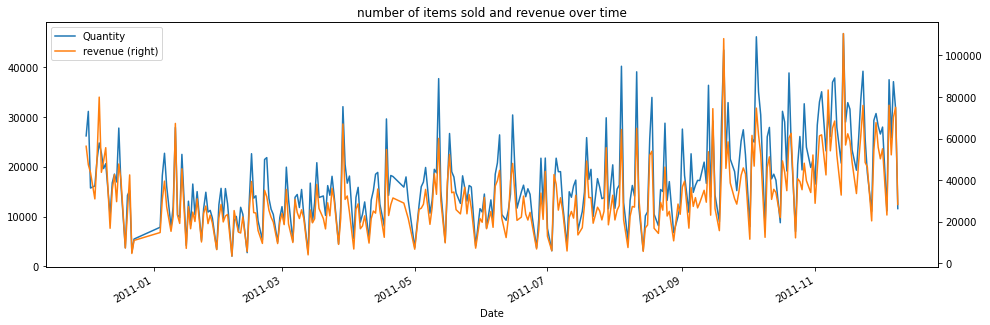

In [171]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and revenue over time', 
    secondary_y='revenue',
    figsize=(16, 5)
)

## Variance of prices per product

We know we have 3914 products in this data. We need variation in unit prices within products to estimate elasticity. We choose to make a histogram of the standard variation of the products to identify the distribution of standard deviation between products. We see that there are price products that do not vary over time.

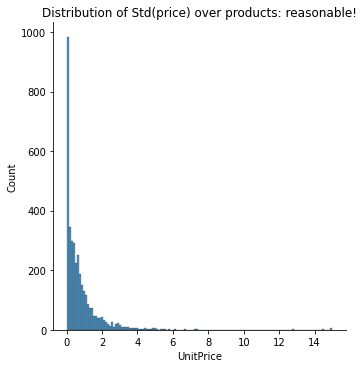

In [172]:
sns.displot(df.groupby('StockCode').UnitPrice.std().dropna().clip(0, 15), kde=False)
plt.title('Distribution of Std(price) over products: reasonable!');

We drop those products which their prices do not vary over time.

In [182]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]

##  Feature Engineering

In [183]:
# Generate Logs of main variables
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

In [186]:
# Get information from dates and stock code
df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

In [187]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies( df_mdl.Date )
# Drop column B as it is now encoded
df_mdl2 = df_mdl.drop('Date',axis = 1).copy()
# Join the encoded df_mdl
df_mdl2 = df_mdl2.join(one_hot)

In [188]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies( df_mdl.Country )
# Drop column B as it is now encoded
df_mdl3 = df_mdl.drop('Country',axis = 1).copy()
# Join the encoded df_mdl
df_mdl3 = df_mdl3.join(one_hot).reset_index( drop = True )

In [189]:
# Get information from description data
# We get tokens and generate columns using words
tokens = CountVectorizer(  min_df=0.0025, ngram_range=(1, 3) ).fit_transform( df_mdl3['Description'] )
df_mdl3 = df_mdl3.join( pd.DataFrame( tokens.toarray() ) )

We could hot encoding Stock Code variable, but it implies to have too much variables and overfitt the ML models. We decide to drop Stock Code fixed effects by de-meaning variables. 

$$
\text{dLnP}_{i,t} = \log(p_{i,t}) - \log(\bar{p_i})
$$

$$
\text{dLnQ}_{i,t} = \log(Q_{i,t}) - \log(\bar{Q_i})
$$

In [185]:
# Note that de-meaning happens on StockCode-level here!
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 

In [209]:
# Drop Variables that are not necessary
df_mdl4 = df_mdl3.drop( ['LnP', 'LnQ', 'Date', 'StockCode', 'Description' ], axis = 1 ).copy()

## Estimating the Price Elasticity Demand

For Double ML we want to orthogonalize outcome $Q$ and variable $P$, given covariates $X$ ($X$ being dimensions that price effect might vary over). Let
$$
\begin{eqnarray}
& Q = P\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid P,X]= 0,\\
& P = m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{eqnarray}
$$

We can estimate data following the Frisch Waugh Lovell theorem:

$$
Z = Q - g_0(X)
$$

$$
V = P - m_0(X)
$$


$$
\check{\theta} = \left(\frac{1}{n} \sum_{i\in I} \hat{V}_i P_i\right)^{-1} \frac{1}{n} \sum_{i\in I} \hat{V}_i (\hat{Z}_i).
$$

We generate $\hat{g_0(X)}$ and $\hat{m_0(X)}$ using machine learning models. Additionally, we use cross validation to avoid overfitting.

In [219]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(data_dml_base,
                                ml_g = lasso,
                                ml_m = lasso,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
dml_plr_lasso.summary

lasso_summary = dml_plr_lasso.summary

In [ ]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)

# Initialize DoubleMLPLR model
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                ml_g = lasso,
                                ml_m = randomForest,
                                n_folds = 3)
np.random.seed(123)
dml_plr_forest.fit(store_predictions=True)


forest_summary = dml_plr_forest.summary

forest_summary

In [222]:
# Trees
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_g = trees,
                               ml_m = trees,
                               n_folds = 3)

dml_plr_tree.fit(store_predictions=True)
tree_summary = dml_plr_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-0.706396,0.004909,-143.906235,0.0,-0.716017,-0.696775


In [224]:
from xgboost import XGBClassifier, XGBRegressor

c:\python\python38\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [226]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_g = boost,
                                ml_m = boost,
                                n_folds = 3)
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-1.31458,0.010696,-122.907898,0.0,-1.335543,-1.293617


In [227]:
plr_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
plr_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
plr_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,-1.655070,-1.681617,-1.628523
forest,-1.122407,-1.137005,-1.107808
tree,-0.706396,-0.716017,-0.696775
xgboost,-1.314580,-1.335543,-1.293617


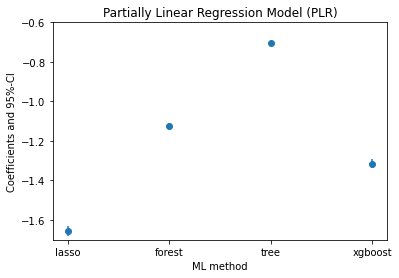

In [230]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-1.7, -0.6])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

We have a very big differences between the estimations using different ML models.